# ベイジアン 固定効果モデル

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [2]:
filepath = '../../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   island_names              1900 non-null   object 
 1   years                     1900 non-null   int64  
 2   island_ids                1900 non-null   int64  
 3   region_codes              1900 non-null   object 
 4   region_names              1900 non-null   object 
 5   prefecture_codes          1900 non-null   int64  
 6   populations               1697 non-null   float64
 7   treatment_group           1900 non-null   int64  
 8   treatment_group_mainland  1900 non-null   int64  
 9   year_bridges_opened       1900 non-null   int64  
 10  after_treated             1900 non-null   int64  
 11  year_connect_mainland     1900 non-null   int64  
 12  after_treated_mainland    1900 non-null   int64  
 13  income                    1401 non-null   float64
 14  prefectu

In [11]:
# 標準化する列を選択
df['log_income'] = np.log(df['income'])
columns_to_scale = ['log_income', 'elementary_school', 'junior_high_school', 'high_school', 'hospital']

# 標準化
scaler = StandardScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


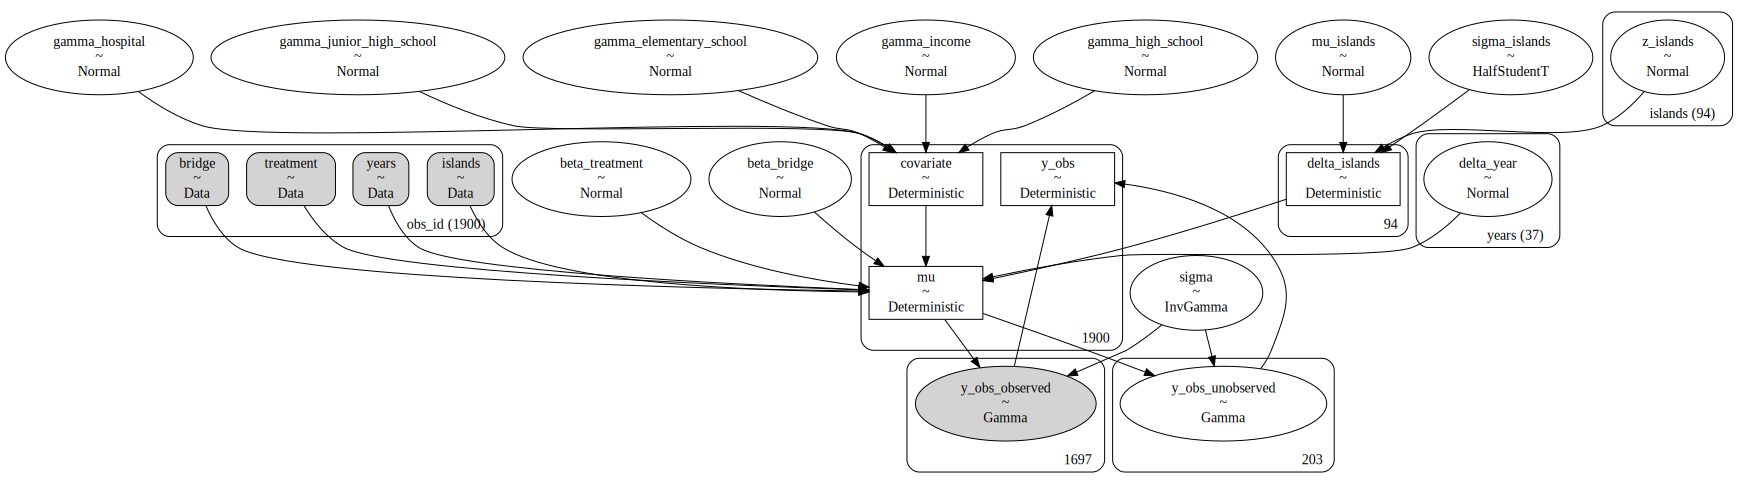

In [ ]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])

COORDS = {
    'islands': df['island_ids'].unique(),
    'years': df['years'].unique(),
    'obs_id': df.index
}

y_values = df['populations'].values
log_income = df['log_income']
elementary_school = df['elementary_school']
junior_high_school = df['junior_high_school']
high_school = df['high_school']
hospital = df['hospital']

with pm.Model(coords=COORDS) as model:
    # Data
    islands = pm.Data('islands', df['island_ids'], dims='obs_id')
    years = pm.Data('years', df['years'], dims='obs_id')
    treatment = pm.Data('treatment', df['treatment_group'], dims='obs_id')
    bridge = pm.Data('bridge', df['after_treated'], dims='obs_id')

    # Priors
    beta_treatment = pm.Normal('beta_treatment', mu=0, sigma=100)
    beta_bridge = pm.Normal('beta_bridge', mu=0, sigma=100)
    gamma_income = pm.Normal('gamma_income', mu=0, sigma=100)
    gamma_elementary_school = pm.Normal('gamma_elementary_school', mu=0, sigma=100)
    gamma_junior_high_school = pm.Normal('gamma_junior_high_school', mu=0, sigma=100)
    gamma_high_school = pm.Normal('gamma_high_school', mu=0, sigma=100)
    gamma_hospital = pm.Normal('gamma_hospital', mu=0, sigma=100)

    mu_islands = pm.Normal('mu_islands', mu=0, sigma=100)
    sigma_islands = pm.HalfStudentT('sigma_islands', nu=3, sigma=100)
    z_islands = pm.Normal('z_islands', mu=0, sigma=1, dims='islands')
    delta_islands = pm.Deterministic('delta_islands', mu_islands + z_islands * sigma_islands)
    delta_years = pm.Normal('delta_year', mu=0, sigma=100, dims='years')
    sigma = pm.InverseGamma('sigma', alpha=0.001, beta=0.001)

    # linear model
    covariate = pm.Deterministic(
        'covariate',
        gamma_income * log_income + gamma_elementary_school * elementary_school + gamma_junior_high_school * junior_high_school + gamma_high_school * high_school + gamma_hospital * hospital
    )

    mu = pm.Deterministic(
        'mu',
        beta_treatment * treatment + beta_bridge * bridge + covariate + delta_islands[islands] + delta_years[years]
    )

    # Likelihood
    y_obs = pm.Gamma('y_obs', alpha=mu, beta=sigma, observed=y_values)
    # y_missing = pm.Data('y_missing', df['populations'].isnull(), dims='obs_id')

# モデルの視覚化
pm.model_to_graphviz(model)

In [23]:
with model:
    idata = pm.sample(
        draws=2000,
        tune=2000,
        nuts_sampler="numpyro",
        return_inferencedata=True,
        chains=2,
        cores=4,
        target_accept=.998,
    )

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:763: RuntimeWarning: divide by zero encountered in power
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:763: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:763: RuntimeWarning: divide by zero encountered in power
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:763: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


KeyboardInterrupt: 

## アウトプットの保存

In [23]:
az.to_netcdf(idata, 'fixed_effects.nc')

'fixed_effects.nc'

## アウトプットのエクスポート

In [8]:
idata = az.from_netcdf('fixed_effects.nc')

In [19]:
az.summary(idata)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_treatment,-0.905,0.014,-0.918,-0.891,0.010,0.008,2.0,2.0,4876400.29
beta_bridge,-0.218,0.680,-0.898,0.462,0.480,0.407,2.0,2.0,4876400.29
gamma_income,-0.649,0.350,-0.998,-0.299,0.247,0.209,2.0,2.0,4876400.29
gamma_elementary_school,-0.137,0.094,-0.231,-0.044,0.066,0.056,2.0,2.0,4876400.29
gamma_junior_high_school,-0.311,0.248,-0.559,-0.063,0.175,0.148,2.0,2.0,4876400.29
...,...,...,...,...,...,...,...,...,...
y_obs[1895],398.000,0.000,398.000,398.000,0.000,0.000,4000.0,4000.0,NaN
y_obs[1896],365.000,0.000,365.000,365.000,0.000,0.000,4000.0,4000.0,NaN
y_obs[1897],343.000,0.000,343.000,343.000,0.000,0.000,4000.0,4000.0,NaN
y_obs[1898],284.000,0.000,284.000,284.000,0.000,0.000,4000.0,4000.0,NaN


In [ ]:
az.plot_trace(idata, figsize=(18, 15))  # サイズを調整

In [27]:
posterior_samples = idata.posterior

# 0以上のサンプルの割合を計算
prob_beta_bridge_positive = np.mean(posterior_samples['beta_bridge'] > 0)
print(f"Pr(beta_bridge > 0) = {prob_beta_bridge_positive:.4f}")
prob_beta_income_positive = np.mean(posterior_samples['gamma'] > 0)
print(f"Pr(gamma_income > 0) = {prob_beta_income_positive:.4f}")
prob_sigma_positive = np.mean(posterior_samples['sigma'] > 0)
print(f"Pr(sigma > 0) = {prob_sigma_positive:.4f}")

Pr(beta_bridge > 0) = 0.9205
Pr(gamma_income > 0) = 0.1450
Pr(sigma > 0) = 1.0000
